In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as plot_style
import sys
plot_style.use('plots.mplstyle')

In [2]:
from virtual_lab.experiments import *
from virtual_lab.simulation import *
from virtual_lab.model import *
from virtual_lab.utils import *
Sim = Simulation()

Initializing a simulation without a given model, a model should be added before running any experiment by calling Simulation.add_model()


In [3]:
#TODO : Add 0.2 Hz experiments
#TODO: stc for depression -> Doesn't work, but not sure that's a problem, didn't find any experimental evidence for it anyways
#TODO: comparison on how LTP is affected by induction of additional LTPs at a certain moment


# Trying out different models

## Model with normal $V_d$ non linearity and $V_n$

In [4]:
class BaseModel(Model):
    def latex_equations(self):
        eq = [r'$\frac{dV_d}{dt} = \mathrm{b}n_f(t) + \left(\frac{V_{PSD}-V_s-V_d}{\tau_V}\right)\frac{V_d}{V_{d,eq}} + k_uV_s - k_bV_d$',
              r'$\frac{dV_s}{dt} = k_bV_d - k_uV_s$',
              r'$\frac{dV_{PSD}}{dt} = \phi(t)\frac{V_d+V_s-V_n}{\tau_{PSD}}$',
              r'$V_n = \mathrm{sol}\left(\frac{dV_d}{dt}+\frac{dV_s}{dt} = 0\right)(V_{PSD})$']
        return eq

    def diff_equations_dict(self):
        #super().list_of_equations(variables)
        needed_variables = ["Vd","Vs","Vpsd"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model, but was not given at initialisation")
        return {
            "Vd": self.dVd,
            "Vs": self.dVs,
            "Vpsd": self.dPSD
        }
    def equations_dict(self):
        needed_variables = ["V_n"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model, but was not given at initialisation")
        return {
            "V_n": self.V_n_calc,
            "V_tot": self.V_tot_calc
        }

    def set_initial_values(self,stochastic_simulation):
        self.eql  = self.k_u_0/self.k_b_0 / (1+self.k_u_0/self.k_b_0)
        self.eql2  = self.k_u_1/self.k_b_1 / (1+self.k_u_1/self.k_b_1)
        if stochastic_simulation:
            # This is a bit of a cheat, but I'll check if without this it still works.
            # TODO: check!
            self.nf_0 = np.mean(self.nf)
        self.variables.V_n = self.nu*self.nf_0*self.tau_Vd + self.variables.Vpsd 
        self.variables.Vd =  self.eql    * self.variables.V_n
        self.variables.Vs = (1-self.eql) * self.variables.V_n
        self.Vd_0 = self.variables.Vd 
        self.variables.V_tot = self.variables.Vs + self.variables.Vd
    
    def quantity_dependencies(self):
        needed_quantities = ["k_u_1","k_b_1","nf_LTD","nf_LTP"]
        for q in needed_quantities:
            if not hasattr(self,q):
                raise AttributeError(f"The following quantity is not defined in the model, but it is needed by the experimental procedure {q}\n"
                "Make sure you define all the needed constants before running a simulation")
        dependencies = {
            "k_u": {"xlinkers": self.k_u_1},
            "k_b": {"xlinkers": self.k_b_1},
            "protein": {"protein": 1},
            "nf": {"stim": self.nf_LTP,
                     "LFS": self.nf_LTD},
            "gamma": {"stim": self.g_mul_LTP*self.gamma_0,
                      "LFS": self.g_mul_LTD*self.gamma_0},
            "mu" : {"stim": self.m_mul_LTP*self.mu_0,
                    "LFS": self.m_mul_LTD*self.mu_0}
        }
        return dependencies
    
    def stochastic_variables_dict(self):
        stochastic_variables = {
            "nf" : (bd_process,["gamma","mu"])
        }
        return stochastic_variables
            
    # def termalization_step(self,t):
    #     var = {}
    #     var["Vd"] = self.dVd( t) 
    #     # Vs grows and shrinks through x-linker binding and unbinding
    #     var["Vs"] = self.dVs(t)
    #     self.variables.diff_timestep(var,self.dt)

    def dVd(self,t): # Vd with V-dependent removal: Dynamic pool shrinks if V>PST_str, Growth with number of foci 
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        return self.nu*self.nf[t]*(Vd/self.Vd_0)**self.AFB  - (Vd+Vs-Vpsd)/self.tau_Vd*(Vd/self.Vd_0)**self.DVD  - self.k_b[t]*Vd + self.k_u[t] *Vs
    
    def dVs(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        return self.k_b[t]*Vd - self.k_u[t] *Vs 

    def dPSD(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        V_n = self.variables.V_n
        PSD = self.protein[t]*(Vd+Vs - V_n)/(self.tau_PSD_mol*V_n)
        return PSD

    def V_n_calc(self,t,**kwargs):
        PSD = kwargs.get('attractor',self.variables.Vpsd)
        pre = PSD*self.k_u_0
        root = self.k_u_0*(4*self.Vd_0*self.nu*self.nf_0*self.tau_Vd*(self.k_u_0 + self.k_b_0)+self.k_u_0*PSD**2)
        root = np.sqrt(root) if root>0 else 0
        den = 2*self.k_u_0
        #print("V_n calculated", pre+root/den)
        return (pre + root)/den
    
    def V_n_linear(self,t,**kwargs):
        return self.nu*self.nf[t]*self.tau_Vd + self.variables.Vpsd
    
    def V_tot_calc(self,t):
        return self.variables.Vd + self.variables.Vs

In [5]:
# Making the constants optimal for this model
const_base = CONSTANTS.copy()
const_base.update({
    "tau_Vd" : 8000,
    # Crosslinker binding rates
    "k_u_0" : 1/2/3600, # Basal transition rates between stable and dynamic pool
    "k_b_0" : 1/2/600, # CaMKII active (unbound) for about 1 min after LTP (Lee et al 2009)
    })
base_model = BaseModel("Base", {"Vd":None,"Vs":None,"Vpsd":1,"V_n":None,"V_tot":None},const = const_base)
Sim.add_model(base_model)

Switching to model Base


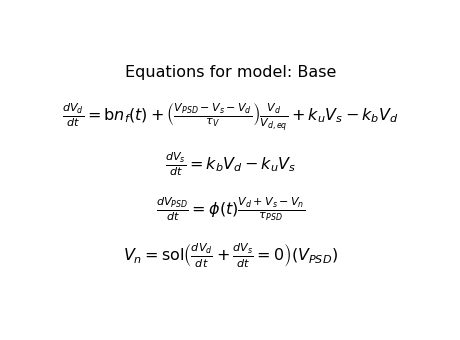

In [6]:
Sim.model_equations()

## Momentum Model -> A bit of a monster

So, this I can make work pretty well with the addition of a few extra parameter changes (one for enlarging the synapse, and one for the shrinkage). Biophysically, they're both plausible as they could account for the concentration of  dp- and p-cofilin (respectively active and inactive) in the synapse. In that case, the balance between polymerization and depolymerization is shifted. This could be introduced in the $V_d$ variable, but that would still not reproduce the complex STC experiments, which with this model we can do. One thing to look up is how long the dephosphorylated cofilin is present in large amounts during LTD. -> No luck so far..

MAYBE: You could define $V_e$ as the volume of the synapse in equilibrium (no nucleation), given a certain concentration of d-cofilin vs p-cofilin. This is the attractor for the stable and dynamic pool due to physical forces (as in Bonilla-Quintana-Fauth), and its value shifts depending on environmental conditions. Specifically, if the balance between inactive and active cofilin is shifted, the result will be a change in volume, as you'll either have uncontrolled severing (depression) or, depending on the amount of available actin close to the spine neck ($\sim Vs$), you will start constructing the enlargement pool. I have no clue if this is accurate, out of the few variations I implemented this seems to work the best. 
So in a way this acts as a proxy attractor for the PSD "volume", in the sense that the PSD will also be affected by these mechanisms, indirectly in the case of the enlargement pool, and directly in the case of severing (you're cutting down the actin supporting structure).

In [7]:
class MomentumModel(BaseModel):
    def latex_equations(self):
        eq = [r'$\frac{dV_d}{dt} = \mathrm{b}n_f(t) + \left(\frac{V_{e}-V_s-V_d}{\tau_V}\right)\frac{V_d}{V_{d,eq}} + k_uV_s - k_bV_d$',
              r'$\frac{dV_s}{dt} = k_bV_d - k_uV_s$',
              r'$\frac{dV_e}{dt} = \frac{k_b}{k_u}\frac{V_{tot}-V_n}{\tau_{V_e}} + \frac{V_{psd}- V_e}{\tau_{decay}}$',
              r'$\frac{dV_{PSD}}{dt} = \phi(t) \frac{V_e-V_{psd}}{\tau_P}$']
        return eq
        
    def diff_equations_dict(self):
        _dict = super().diff_equations_dict()
        needed_variables = ["Ve"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model")
        _dict["Ve"] = self.dVe
        return _dict
    
    def set_initial_values(self,stochastic_model):
        super().set_initial_values(stochastic_model)
        self.variables.Ve = self.variables.Vpsd
    
    
    def dVd(self, t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        Ve = self.variables.Ve
        return self.nu*self.nf[t]*(Vd/self.Vd_0)**self.AFB  - (Vd+Vs-Ve)/self.tau_Vd*(Vd/self.Vd_0)  - self.k_b[t] *Vd  + self.k_u[t] *Vs
 
    def dVe(self,t):
        V_tot = self.variables.V_tot
        V_n = self.variables.V_n
        Ve = self.variables.Ve
        Vd = self.variables.Vd
        Vs = self.variables.Vs
        Vpsd = self.variables.Vpsd
        return self.k_b[t]/self.k_u[t]*(V_tot - V_n)/(self.tau_add_Ve) + (Vpsd - Ve)/(self.tau_Ve)
    
    def dPSD(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        V_n = self.variables.V_n
        Ve = self.variables.Ve
        Vpsd = self.variables.Vpsd
        PSD = self.protein[t]*(Ve - Vpsd)/(self.tau_PSD_mol) # ((np.sign(Ve-Vpsd)-1)/2)*(Vpsd-Ve)/self.tau_Ve
        return PSD
    
    def V_n_calc(self, t):
        return super().V_n_calc(t,attractor = self.variables.Ve)

# BasicExperiments.add_event("enlargement",[E_ONSET,X_ENLARGE],concurrence = "stim")
# BasicExperiments.add_event("shrinkage",[E_ONSET,X_SHRINK],concurrence = "LFS")

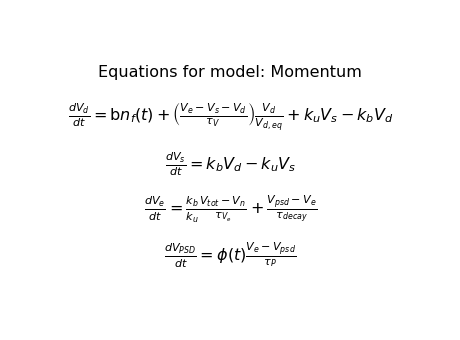

In [8]:
# Optimizing constants for this model
const_momentum = CONSTANTS.copy()
enlarge_dict = {# Enlargement pool
    # Crosslinker binding rates
    "k_u_0" : 1/2.5/3600, # Basal transition rates between stable and dynamic pool
    "k_b_0" : 1/2.5/600, # CaMKII active (unbound) for about 1 min after LTP (Lee et al 2009)
    "tau_add_Ve":5400, #120
    "tau_Ve": 3300,
    # Dynamic pool timescale
    "tau_Vd": 5400}
const_momentum.update(enlarge_dict)
mom_model = MomentumModel("Momentum",{"Vd": None, "Vs": None, "Vpsd": 1., "V_n": None,"V_tot": None,"Ve": None}, const = const_momentum)
Sim.add_model(mom_model,switching=False)
Sim.model_equations(["Momentum"])

In [9]:
early_consolidation = BaseModel("EC", {"Vd":None,"Vs":None,"Vpsd":1,"V_n":None,"V_tot":None},const = const_base)
early_consolidation.const
Sim.add_model(early_consolidation,switching=False)
# Defining a new set of experiments for this particular case
ECExperiments = BasicExperiments.copy()
ECMetaplasticity = MetaPlasticityExperiments.copy()
ECTagReset = TagResetExperiments.copy()
onset = 12.5*60 # 13 seems to be the best value with a decay of 8000 s
for experiments in [ECExperiments,ECMetaplasticity,ECTagReset]:
    for exp in experiments:
        new_protein = []
        for ton,toff in exp.protein:
            diff = P_ONSET - onset if ton > P_ONSET-onset else 0
            new_protein.append([ton-diff,toff-diff])
        exp.protein = new_protein
ECExperiments.experiments[2].protein

[[1050.0, 4650.0]]

# LTP and LTD Experiments & Comparison

Simulating 1 experiments took: 3.772 s
Simulating 1 experiments took: 0.158 s
Plotting 1 experiments


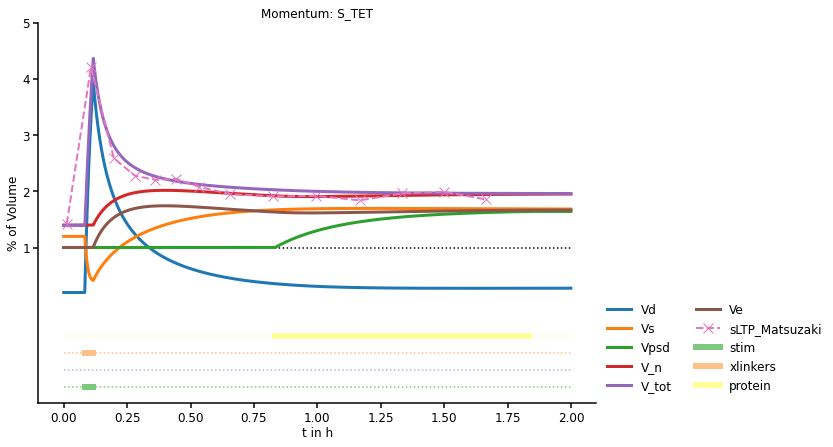

In [13]:
LTP_LTD = Experiments([S_TET,LTD,W_TET,W_LFS])
W_TET.T = 20*3600
NO_STIMULI.T = 10*3600
#mom_model.stop_recording_variables("V_n")
for model in ["Momentum"]:
    Sim.switch_model(model)
    if model == "EC":
        _ = Sim.run_experiments(ECExperiments)
    else:
        stoc = Sim.run_experiments(S_TET,n_of_runs=10,stochastic=True,termalize=True,record_termalization=False)
        det = Sim.run_experiments(S_TET)
Sim.plot_volumes(filename = "pass.pdf",time_unit = "h")

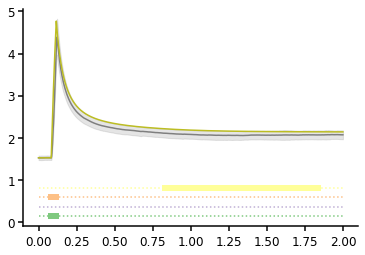

In [16]:
Sim.compare_experiment_results([stoc[0],det[0]],["V_tot"],stochastic_styling = "mean", rescale = True, time_unit = "h")

# Tag reset experiments comparison

Simulating 29 experiments took: 1.054 s
Simulating 1 experiments took: 0.110 s
Making 1 plots


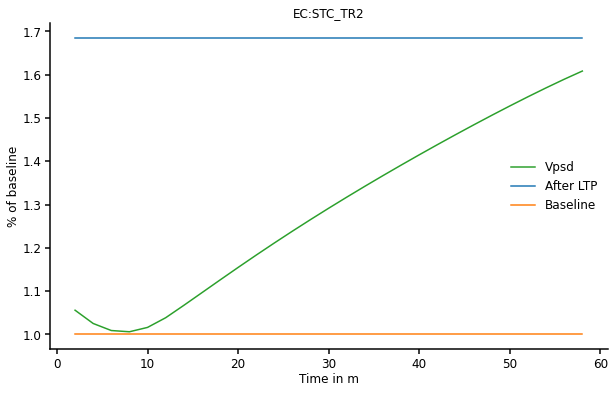

In [ ]:
do_not_record = {
    "Vd" : False,
    "Vs" : False,
    "V_n": False
}
# TODO allow for comparison of different model results!
for model in ["EC"]:
    Sim.models[model].stop_recording_variables(do_not_record)
    Sim.switch_model(model)
    if model == "EC":
        tr_results = Sim.run_experiments(ECTagReset,save_results=False)
        reference_LTP = Sim.run_experiments(ECExperiments.experiments[2]) # 2 corresponds to LTP exp
    else:
        tr_results = Sim.run_experiments(TagResetExperiments,save_results=False)
        reference_LTP = Sim.run_experiments(S_TET)
    x_data = [tr_results[i]["experiment"].LFS[0][0] -300 for i in range(len(tr_results))]
    # Take as reference the value of the PSD after potentiation
    reference_values = [reference_LTP[0]["Vpsd"][-1],1]
    Sim.plot_selected_points(tr_results,"Vpsd","last",event_type="LFS", x_data = x_data, reference_values=reference_values,
    ref_labels = ['After LTP','Baseline'],filename = f"{model}_tag_resetting.pdf")

# Metaplasticity experiments and comparison

In [ ]:
meta_results = []
Sim.switch_model("Base")
meta_results = Sim.run_experiments(LTP_META)
Sim.switch_model("Momentum")
meta_results.append(Sim.run_experiments(LTP_META)[0])
Sim.plot_selected_points(meta_results,["Vpsd","V_tot"],"last_before_event",["stim","LFS"],filename = f"metaplasticty.pdf")

# Next steps:
- Optimize the TagResetting result for Momentum model.
- Find biological explanation for the "gating" of the $V_e$ variable
- Find better names for constants and variables
- (MAYBE) Try including the receptor content based on Moritz 2021, just to see if it comes out